In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import  seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({"axes.labelpad":10})
%config InlineBackend.figure_format = "svg"
pd.set_option("display.max_columns",None)
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import category_encoders
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
kfold = StratifiedKFold(n_splits=30)

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission.csv")
var = pd.read_csv("VariableDefinitions.csv")

In [3]:
print("Train",train.shape,"\nTest",test.shape)

Train (23524, 13) 
Test (10086, 12)


In [4]:
test_id = test.pop("uniqueid")
train_id = train.pop("uniqueid")
total_id = pd.concat([train_id, test_id]).reset_index(drop=True)
total_df = pd.concat([train,test]).reset_index(drop=True).drop("bank_account", axis=1)

In [5]:
sub

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0
...,...,...
33605,uniqueid_2998 x Uganda,0
33606,uniqueid_2999 x Uganda,0
33607,uniqueid_3000 x Uganda,0
33608,uniqueid_3001 x Uganda,0


In [6]:
test.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [7]:
train.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   bank_account            23524 non-null  object
 3   location_type           23524 non-null  object
 4   cellphone_access        23524 non-null  object
 5   household_size          23524 non-null  int64 
 6   age_of_respondent       23524 non-null  int64 
 7   gender_of_respondent    23524 non-null  object
 8   relationship_with_head  23524 non-null  object
 9   marital_status          23524 non-null  object
 10  education_level         23524 non-null  object
 11  job_type                23524 non-null  object
dtypes: int64(3), object(9)
memory usage: 2.2+ MB


In [9]:
for i in range(var.shape[0]):
    print(var["Variable Definitions"][i],": ",var["Unnamed: 1"][i],end="\n\n")

country :  Country interviewee is in.

year :  Year survey was done in.

uniqueid :  Unique identifier for each interviewee

location_type :  Type of location: Rural, Urban

cellphone_access :  If interviewee has access to a cellphone: Yes, No

household_size :  Number of people living in one house

age_of_respondent :  The age of the interviewee

gender_of_respondent :  Gender of interviewee: Male, Female

relationship_with_head :  The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know

marital_status :  The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know

education_level :  Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA

job_type :  Type of job interviewee has: Farming and Fishing, Self employed, Formally em

# Baseline model

In [10]:
baseline = train.copy()
target = baseline.pop("bank_account").replace({"Yes":1,"No":0})

In [11]:
baseline.head(3)

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed


# Model Evaluation using pipeline

In [12]:
def model_evaluation(data, target):
    train_acc_score = []
    test_acc_score = []
    pipe = Pipeline(steps=[
        ("Column transformer",category_encoders.OneHotEncoder(cols=data.columns ,use_cat_names=True)),
        ("Model",CatBoostClassifier(silent=True))
    ])
    
    for (train_split,test_split) in kfold.split(data, target):
        xtrain, xtest = data.iloc[train_split], data.iloc[test_split]
        ytrain, ytest = target[train_split], target[test_split]
        pipe.fit(xtrain, ytrain)
        train_pred = pipe.predict(xtrain)
        test_pred = pipe.predict(xtest)
        train_acc_score.append(accuracy_score(ytrain, train_pred))
        test_acc_score.append(accuracy_score(ytest, test_pred))
        
    print(f"\n\nAccuracy score for training data: {np.mean(train_acc_score)}\n\nAccuracy score for validation data: {np.mean(test_acc_score)}")
    
    return pipe

In [13]:
model_evaluation(baseline, target)



Accuracy score for training data: 0.9088165300372554

Accuracy score for validation data: 0.8853556263269639


Pipeline(steps=[('Column transformer',
                 OneHotEncoder(cols=Index(['country', 'year', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object'),
                               use_cat_names=True)),
                ('Model',
                 <catboost.core.CatBoostClassifier object at 0x000001B7B50616D0>)])

<AxesSubplot:ylabel='location_type'>

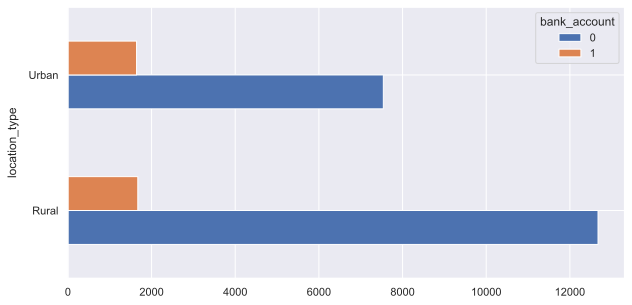

In [14]:
pd.crosstab(index=baseline["location_type"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='country'>

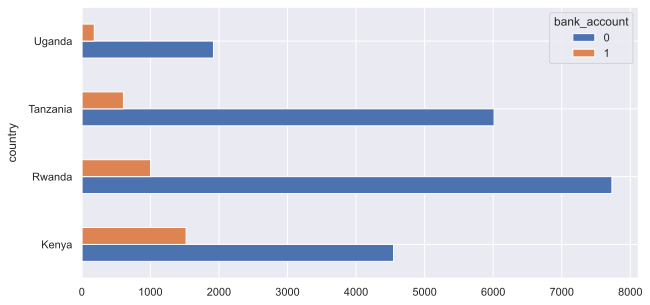

In [15]:
pd.crosstab(index=baseline["country"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='relationship_with_head'>

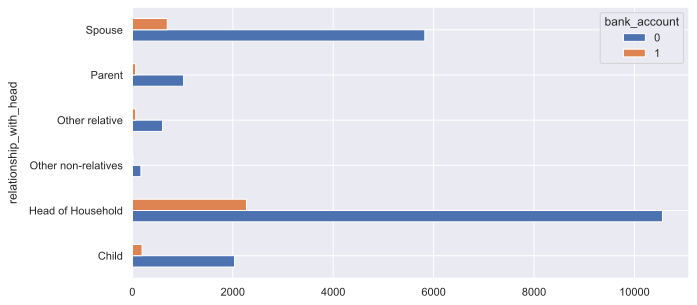

In [16]:
pd.crosstab(index=baseline["relationship_with_head"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='education_level'>

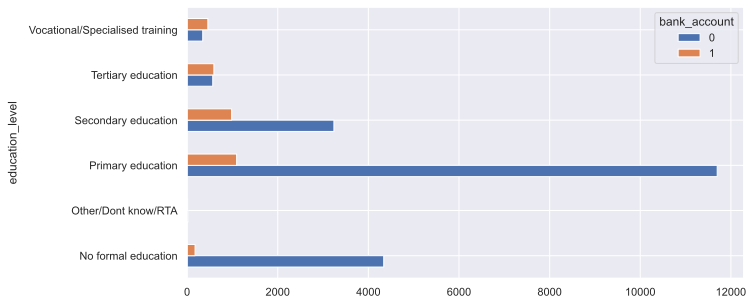

In [17]:
pd.crosstab(index=baseline["education_level"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='marital_status'>

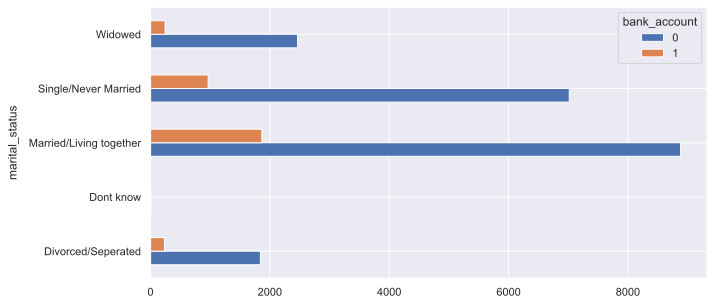

In [18]:
pd.crosstab(index=baseline["marital_status"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='cellphone_access'>

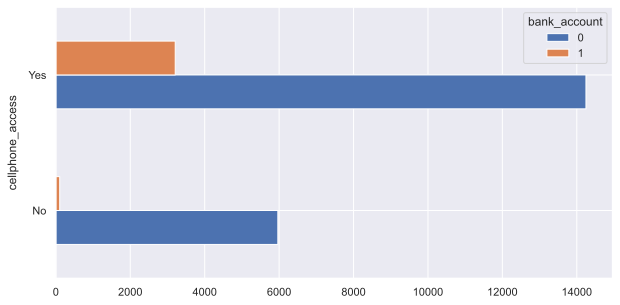

In [19]:
pd.crosstab(index=baseline["cellphone_access"], columns=target).plot(kind="barh")

<AxesSubplot:ylabel='year'>

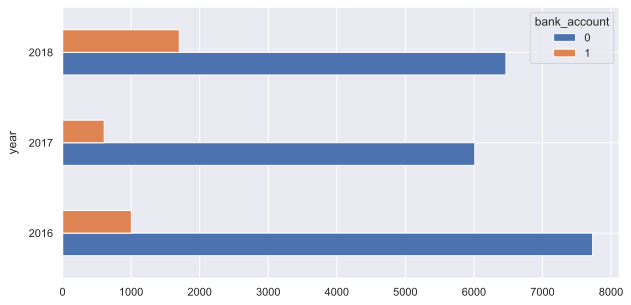

In [20]:
pd.crosstab(index=baseline["year"], columns=target).plot(kind="barh")

In [21]:
baseline.corr()

,year,household_size,age_of_respondent
year,1.000000,-0.052264,-0.019330
household_size,-0.052264,1.000000,-0.129729
age_of_respondent,-0.019330,-0.129729,1.000000


In [22]:
baseline["age_of_respondent"] = pd.cut(baseline["age_of_respondent"],bins=[13,19,35,58,100],labels=["Teenager","Youth","Middle age","Old"])
total_df["age_of_respondent"] = pd.cut(total_df["age_of_respondent"],bins=[13,19,35,58,100],labels=["Teenager","Youth","Middle age","Old"])

<AxesSubplot:ylabel='age_of_respondent'>

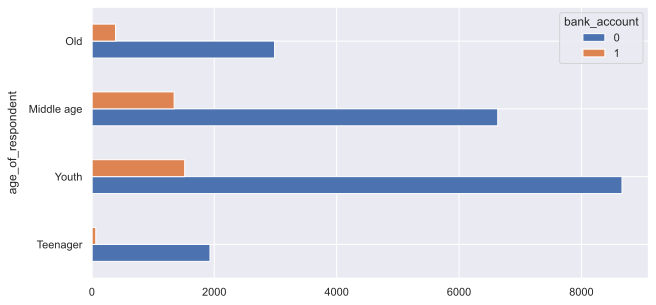

In [23]:
pd.crosstab(index=baseline["age_of_respondent"],columns=target).plot(kind="barh")

In [24]:
pipe = model_evaluation(baseline, target)



Accuracy score for training data: 0.9050610121647473

Accuracy score for validation data: 0.8846322955933966


In [26]:
final_prediction  = pipe.predict(total_df)

In [31]:
pd.DataFrame({"unique_id": total_id + " x " + total_df["country"], "bank_account": final_prediction})#.to_csv(r"C:\Users\HP\Downloads\SUBMISSION.csv",index=False)

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,1
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0
...,...,...
33605,uniqueid_2998 x Uganda,0
33606,uniqueid_2999 x Uganda,0
33607,uniqueid_3000 x Uganda,0
33608,uniqueid_3001 x Uganda,0
